# Do small share of police really draw a third of complaints?
https://www.ft.com/content/141182fc-7727-4af8-a555-5418fa46d09e

    
The FT article from 2012 claimed police complaints were heavily concentrated among what some police accountability advocates term “repeaters” — officers who rack up complaints from the public yet face little discipline."


![title](https://github.com/veronikasamborska1994/data_analysis_example_OWD/blob/main/figures/FT_results_2021.png)


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from utils import *
%matplotlib inline

### Load data on Metropolitan Police complaints between 2018-2022 obtained under a freedom of information request by the reporters at Finanacial Times

Note that there is an issue with this dataset. The data file contains 3 columns: case reference, the id of the officer involved, and the number of complaints on that case. There is no information on the number of cases that each officer had worked on. This means that some officers might receive more complaints than others simply because they work on more cases. 





In [2]:
case_ref, officer_id, complaints_per_case = load_police_data()


subject 122060 has an average of 4 complaints per day
Organisational has an average of 0.24 complaints per day


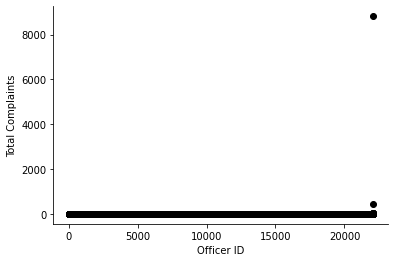

In [16]:
sorted_cases, sorted_ids  = inspect_data(case_ref, officer_id, complaints_per_case)
plt.scatter(np.arange(len(sorted_cases)),sorted_cases, color = 'black'); sns.despine()
plt.xlabel('Officer ID'); plt.ylabel('Total Complaints')

print(str(sorted_ids[-1]) + ' has an average of ' + str(int(sorted_cases[-1]/5/365)) + ' complaints per day')
print(str(sorted_ids[-2]) + ' has an average of ' + str(np.round(sorted_cases[-2]/5/365,2)) + ' complaints per day')


In [ ]:
'''Exclude the subject with an unrealistic # of complaints 
   and what's called Organisational as it's likely to refer to a single officer '''

sorted_cases_cl = sorted_cases[:-2]; sorted_ids_cl = sorted_ids[:-2]

In [4]:
deciles_ = get_decile_data(sorted_cases_cl, sorted_ids_cl)
prob_, deciles_sim = simulate_decile_data(complaints_per_case)

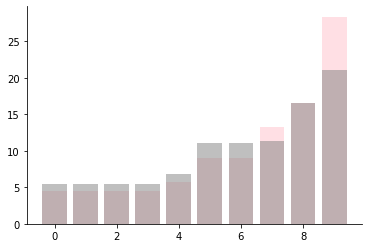

In [5]:
plt.bar(np.arange(len(deciles_)), deciles_, color = 'pink', label = 'real', alpha = 0.5)
plt.bar(np.arange(len(deciles_sim)), deciles_sim, color = 'grey', alpha = 0.5)    
sns.despine()


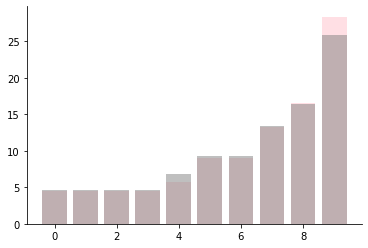

In [6]:
probs = deciles_/np.max(deciles_)
simulated_, years_to, av  = calculate_poisson(probs, 10)
plt.bar(np.arange(len(deciles_)), deciles_, color = 'pink', label = 'real', alpha = 0.5)
plt.bar(np.arange(len(simulated_)), simulated_, color = 'grey', alpha = 0.5)    
sns.despine()


In [7]:
@widgets.interact(last_perc=(0.1, 1))
def plot(last_perc = 0.01):
    quartiles = 10; 
    lamdas = lambdas_sim(last_perc, quartiles)
   
    simulated, years_to,av  = calculate_poisson(lamdas, quartiles)
    fig, ax = plt.subplots(2,1, figsize=(4, 10))
    ax[0].bar(np.arange(len(deciles_)), deciles_, color = 'pink', label = 'real', alpha = 0.5)
    ax[0].bar(np.arange(len(simulated)), simulated, color = 'grey', alpha = 0.5) 

    sns.despine()
    print('Number of Years to Achieve Total --> ' + str(years_to))
    ax[1].hist(lamdas, color = 'pink', alpha = 0.5) 
    sns.despine()
    print('Average % of Officers that had a complaint ' + str(av))


interactive(children=(FloatSlider(value=0.1, description='last_perc', max=1.0, min=0.1), Output()), _dom_class…

In [12]:
@widgets.interact(a = (1, 10),b = (1, 10))
def plot(a = 1, b = 2):
    quartiles = 10
    lamdas = lambdas_sim_graded(a,b, quartiles)
    simulated,years_to,av = calculate_poisson(lamdas, quartiles)
    fig, ax = plt.subplots(2,1, figsize=(4, 10))
    
    ax[0].bar(np.arange(len(deciles_)), deciles_, color = 'pink', label = 'real', alpha = 0.5)
    ax[0].bar(np.arange(len(simulated)), simulated, color = 'grey', alpha = 0.5) 

    hist_, edg = np.histogram(lamdas)
    ax[1].plot(edg[:-1],hist_/quartiles, color = 'pink', alpha = 0.5); 
    ax[1].set_xlim(-0.1,1)
    ax[1].set_xlabel('Probability of Getting a Complaint'); ax[1].set_ylabel('Proportion of Police Officers')
    
    sns.despine()

    print("Top Decile Responsible for " + str(np.round(simulated[-1],1)) + '%')
    print('Number of Years to Achieve Total --> ' + str(years_to))
    print('Average % of complaints per officer ' + str(np.round(av,3))+ '%')

    


interactive(children=(IntSlider(value=1, description='a', max=10, min=1), IntSlider(value=2, description='b', …

In [ ]:
prms = np.arange(0.1, 10, 1);
decile_responsible, average_complaints, years_to_total = simulate_lambdas(prms)

plt.figure(figsize = (4,8))
titles = ['Average % of Complaints per Officer', 'Complaints in the top decile']
plt.subplot(3,1,1); plt.scatter(decile_responsible, average_complaints, color = 'black'); sns.despine()

for i,pl in enumerate([average_complaints, decile_responsible]):
    plt.subplot(3,1,i+2); plt.scatter(pl,years_to_all, color = 'black')
    plt.title(titles[i]);  sns.despine()

plt.tight_layout()

  9%|▉         | 9/100 [00:09<02:21,  1.55s/it]

[0.345 0.365 0.334 0.372 0.351 0.36  0.386 0.319 0.345 0.268 0.272 0.433
 0.305 0.301 0.234 0.275 0.243 0.364 0.26  0.223 0.256 0.272]
[23.4 24.9 22.9 23.8 24.  23.5 22.1 23.6 23.7 23.  24.5 23.2 23.7 23.
 26.  25.3 23.4 23.6 24.  23.9 23.4 22.4]


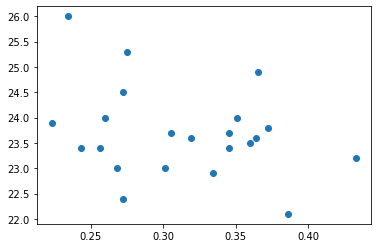

In [38]:
ind_year = np.intersect1d(np.where(np.asarray(years_to_all) > 3)[0], np.where(np.asarray(years_to_all) < 7)[0])

print(np.asarray(average_complaints)[ind_year])
print(np.asarray(decile_responsible)[ind_year])


plt.scatter(np.asarray(average_complaints)[ind_year],np.asarray(decile_responsible)[ind_year])
